In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import IPython
from IPython.display import Audio
from scipy.io import wavfile
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams["figure.figsize"] = (14,4)
import librosa

The goal function are get_info and get_gif, which can be changed for more interesting parameter searching and mappings. 

In [2]:
# take a look at the audio
sr, audio = wavfile.read("snd.wav")
Audio(audio, rate=sr)

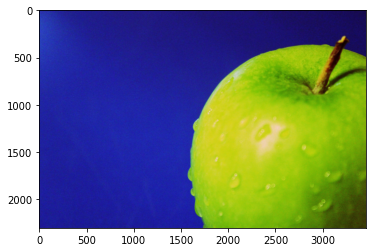

In [3]:
# take a look at the image
img = cv2.imread('AudioImagers/apple.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [4]:
# function that takes audio as input and return different features
def get_info(audio_name, window_size):
    # audio_name -- name of audiofile
    # window_size -- we split audio into frames, this is the length of the frame in seconds
    x, sr = librosa.load(audio_name)
    seconds = len(x) / sr
    frame_len = int(len(x) / (seconds / window_size))
    frames = []
    for ind in range(0, len(x) + 1, frame_len):
        current_amplitude = x[ind:ind + frame_len]
        fft = librosa.stft(current_amplitude, n_fft=len(current_amplitude), hop_length=len(current_amplitude))
        freqs = fft[:, 0]
        freqs = librosa.amplitude_to_db(abs(freqs))
        _, phase = librosa.magphase(fft)
        phase = phase[:, 0]
        frames.append({'amplitude':current_amplitude, 'frequency':freqs, 'phase':phase})
        #timbre = 0
    return frames

In [5]:
audio_name = 'snd.wav'
frames = get_info(audio_name, 0.5)

In [8]:
# helper function that should be different for other approaches of mapping
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    new_img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return new_img

def decrease_brightness(img, value=-30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = -value
    v[v < lim] = 0
    v[v >= lim] -= (-value)

    final_hsv = cv2.merge((h, s, v))
    new_img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return new_img

def change_brightness(img, value=0):
    if value == 0:
        return img
    if value < 0:
        return decrease_brightness(img, value)
    return increase_brightness(img, value)

In [9]:
# function that takes audio info and image as an imput an returns set of images for the frame
def get_gif(info, img_address):
    img = cv2.imread(img_address)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ln = len(info)
    amplitudes = []
    for i in range(ln):
        amplitudes.append(info[i]['amplitude'].max())
    br_values = np.array(amplitudes) / min(amplitudes)
    # this arguments just hand picked, so the images looks different
    # for final version better use proper transformation
    a = 19.14
    b = -64.12
    br_values = br_values * a + b
    br_values = np.array(br_values, dtype=int)
    new_imgs = []
    for v in br_values:
        new_imgs.append(change_brightness(img, v))
    return new_imgs

In [10]:
new_imgs = get_gif(frames, 'AudioImagers/apple.jpg')

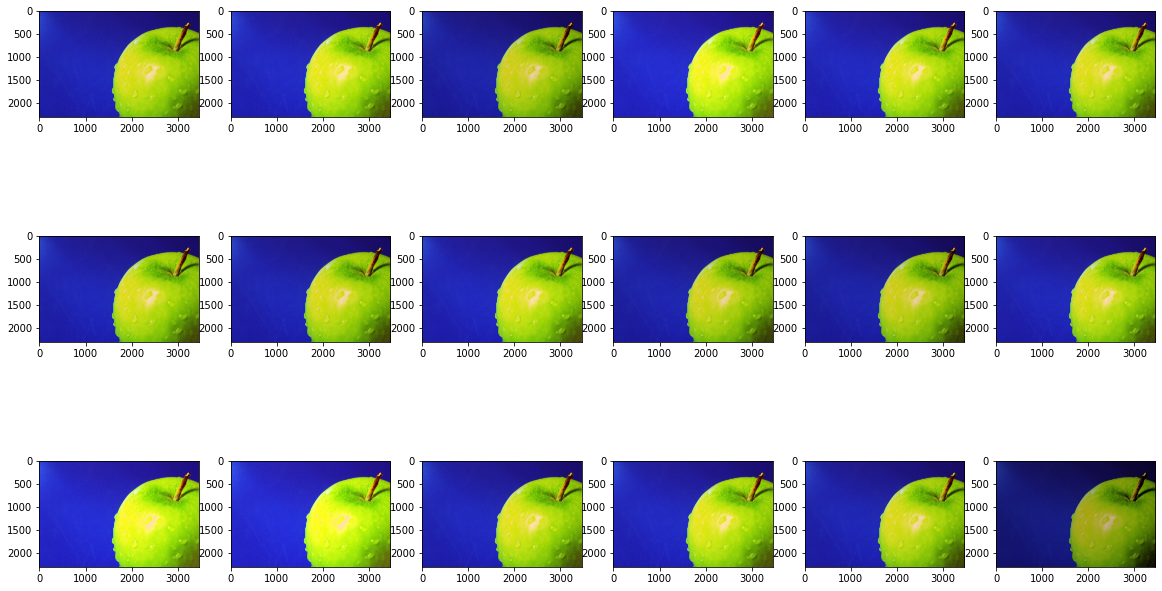

In [11]:
# basic visualization of images in result
fig = plt.figure(figsize=(20, 20))
for i in range(1,len(new_imgs)):
    fig.add_subplot(5,6,i)
    plt.imshow(new_imgs[i])
plt.show()

In [17]:
# this function is for making gif, the problem I didn't find an argument on how to change the time for particular image
# so, it will need additional coding
import imageio
with imageio.get_writer(f'out.gif', mode='I') as writer:
    for new_img in new_imgs:
        writer.append_data(new_img)

Gif saved



Also, here we should collect the similarity metrics vector. 
Approximately, it should look like that:
```
def img_metric(imgs):
    vec = []
    for i in range(len(imgs) - 1):
        vec.append(rmse(imgs[i], imgs[i + 1]))
    return vec
    
def audio_metric(frames):
    ...
    return some_vec

audio_vec = normalize(audio_metric...)
img_vec = normalize(img_metric...)
Goal_metric = cosine_distance(audio_vec, img_vec)
```

The goal is to make the best goal metric, which will be equal to similarity between vectors.